In [1]:
using Test, DataFrames, CSV, Printf
using Plots, LightGraphs, StatsBase

include("markov_aux2.jl")
include("markov2.jl")

nᵢ = CSV.read("C:/Users/pierg/Documents/Julia/MMCA-vaccination/population_surface.csv", DataFrame)
sᵢ = Float64.( nᵢ[:, "Superficie"] )
nᵢ = nᵢ[:, "Population"]
N_tot = sum(nᵢ)

G = 3
M = 52
V = 2

Nᵍ= [12009992, 26409793, 8906906] # Data from INE, provisional as of July 1, 2021 

nᵢᵍ =  Nᵍ/sum(Nᵍ) * nᵢ'
nᵢ = sum(nᵢᵍ, dims = 1)
N_tot = sum(nᵢᵍ)

C = [0.5980 0.3849 0.0171
     0.2440 0.7210 0.0350
     0.1919 0.5705 0.2376]

data = CSV.read("C:/Users/pierg/Documents/Julia/MMCA-vaccination/from_to_flow_provinces.csv", DataFrame)
Rᵢⱼ = zeros(M, M)
for count in 1:nrow(data)
    i = data[count,2]
    j = data[count, 3]
    
    Rᵢⱼ[i, j] = data[count, 4]
end
Rᵢⱼ = Rᵢⱼ ./ sum(Rᵢⱼ, dims = 2)

edgelist, Rᵢⱼ = make_edls(Rᵢⱼ)

kᵍ = [11.8, 13.3, 6.6]
kᵍ_h = [3.15, 3.17, 3.28]
kᵍ_w = [1.72, 5.18, 0.0]
pᵍ = [0.3, 1., 0.05] # [0.3, 1.0, 0.05]
# sᵢ = sample([15., 16., 17., 18, 19., 20., 21., 22., 23., 24., 25. ], M)
ξ = 0.01
σ = 2.5;

In [2]:
# FIRST OF ALL RUN THE SIMULATION WITHOUT VACCINATIONS

# include("markov_aux2.jl")
# include("markov2.jl")

βᴵᵥ = 0.056
βᴬᵥ = 0.5 * βᴵᵥ
ηᵍ = [1, 1, 1] * 0.127
αᵍ = [1, 1, 1] * 0.306
μᵍ = [1, 1, 1] * 0.589

# Rows are the age groups, columns are the vaccination stages
θᵍ = [0.     0.0*(1-0.95);
      0.0  0.0*(1-0.95); 
      0.0  0.0*(1-0.95)]
γᵍ = [0.003  0.003*(1-0.9);
      0.01   0.01*(1-0.9); 
      0.08   0.08*(1-0.9)] 
ωᵍ = [0.  0.0*(1-0.95); 
      0.04  0.04*(1-0.95); 
      0.3  0.3*(1-0.95)]

ζᵍ = [1/7.084, 1/7.084, 1/7.084]
λᵍ = [1/4.084, 1/4.084, 1/4.084]
ψᵍ = [1/7.0, 1/7.0, 1/7.0]
χᵍ = [1/20.0, 1/20.0, 1/20.0]

Λ = 1 / 50 # Waning immunity rate 
Γ = 1 / 100 # Reinfection rate

T = 1200

ϵᵍ = [0.1 , 0.4 , 0.5] * round( N_tot / 200 )
tᶜs = [400, 400+60, T]
ϵᵍs = ϵᵍ .* [0 0 0] # reshape(ϵᵍ, (3, 1))

κ₀s = ones(3) * 0.
ϕs = ones(3) 
δs = ones(3) * 0.

rᵥ = [0., 0.6 ] # Relative risk reduction of the probability of infection
kᵥ = [0., 0.4 ] # Relative risk reduction of the probability of transmission

if (@isdefined epi_params)
    reset_params!(epi_params, population)
end    
population = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ);
epi_params = Epidemic_Params(βᴵᵥ, βᴬᵥ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ,
                             ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, Λ, Γ, rᵥ, kᵥ, G, M, T, V);

## Initialization of the epidemics

E₀ = population.nᵢᵍ/ N_tot * 1000
A₀ = population.nᵢᵍ / N_tot * 1000
I₀ = population.nᵢᵍ / N_tot * 1000
H₀ = population.nᵢᵍ * 0
R₀ = population.nᵢᵍ / N_tot * 23e5 ### NUMERO REALISTICO?
S₁ = (population.nᵢᵍ .- E₀ .- A₀ .- I₀ .- H₀ .- R₀) .* 0.5

set_initial_conditions!(epi_params, population, S₁, E₀, A₀, I₀, H₀, R₀)

# run_epidemic_spreading_mmca!(epi_params, population; ϵᵍ, verbose = true)
run_epidemic_spreading_mmca!(epi_params, population, tᶜs, κ₀s, ϕs, δs, ϵᵍs; verbose = false)

In [3]:
reset_params!(epi_params, population)
set_initial_conditions!(epi_params, population, S₁, E₀, A₀, I₀, H₀, R₀)

# run_epidemic_spreading_mmca!(epi_params, population; ϵᵍ, verbose = true)
run_epidemic_spreading_mmca!(epi_params, population, tᶜs, κ₀s, ϕs, δs, ϵᵍs; verbose = false)

In [7]:
# CALL THE SIMULATION WITHOUT VACCINATION "BASELINE"

baseline = (cases = time_series(epi_params, population).cases,
            hosps = time_series(epi_params, population).icus,
            deaths = time_series(epi_params, population).deaths )

# We define the second peak as the next-to-highest one
idx = maxima(baseline.cases).height .== sort(maxima(baseline.cases).height, rev=true)[2]
idx = findall(idx)[1]

t_peak = maxima(baseline.cases).position[1]
t_peak2 = maxima(baseline.cases).position[idx]

h_peak_cases2 = maxima(baseline.cases).height[idx]
h_peak_hosp2 = maxima(baseline.hosps).height[idx]

t_range = t_peak2 - t_peak
h_peak_hosp2

74434.89174116967

In [ ]:
t_peak = 89
t_peak = 273
t_range = t_peak2 - t_peak
h_peak_cases2 = 1.5212268900064155e6
h_peak_hosp2 = 74434.89174116967

In [45]:
###### PLOT DISPLAYING THE DIFFERNCE OF THE WAVES WITH AND WITHOUT VACCINATION #######
T = 400

## INTERVENTION 1
ϵᵍ = [0.1 , 0.4 , 0.5] * round( N_tot / 200 )
t_start1 = 40
duration1 = 60
tᶜs = [t_start1, t_start1 + duration1, T]
ϵᵍs = ϵᵍ .* [0 1 0] # reshape(ϵᵍ, (3, 1))

if (@isdefined epi_params)
    reset_params!(epi_params, population)
end    
population = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ);
epi_params = Epidemic_Params(βᴵᵥ, βᴬᵥ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ,
                             ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, Λ, Γ, rᵥ, kᵥ, G, M, T, V);

set_initial_conditions!(epi_params, population, S₁, E₀, A₀, I₀, H₀, R₀)
run_epidemic_spreading_mmca!(epi_params, population, tᶜs, κ₀s, ϕs, δs, ϵᵍs; verbose = false)
intervention1 = time_series(epi_params, population).cases;

## INTERVENTION 2
ϵᵍ = [0.1 , 0.4 , 0.5] * round( N_tot / 200 )
t_start2 = 110
duration2 = 90
tᶜs = [t_start2, t_start2 + duration2, T]
ϵᵍs = ϵᵍ .* [0 1 0] # reshape(ϵᵍ, (3, 1))

if (@isdefined epi_params)
    reset_params!(epi_params, population)
end    
population = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ);
epi_params = Epidemic_Params(βᴵᵥ, βᴬᵥ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ,
                             ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, Λ, Γ, rᵥ, kᵥ, G, M, T, V);

set_initial_conditions!(epi_params, population, S₁, E₀, A₀, I₀, H₀, R₀)
run_epidemic_spreading_mmca!(epi_params, population, tᶜs, κ₀s, ϕs, δs, ϵᵍs; verbose = false)
intervention2 = time_series(epi_params, population).cases;

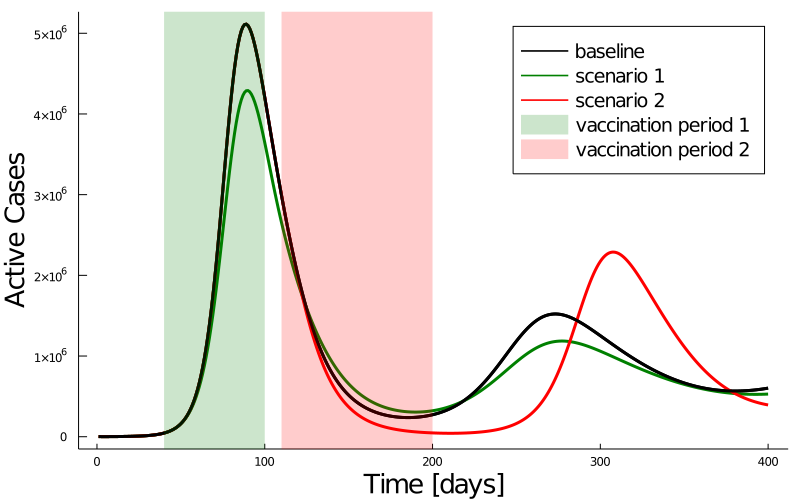

In [63]:
range = 1:400
plot(size = (800, 500), grid = false, xlabel = "Time [days]", ylabel = "Active Cases", legendfont=font(13), xguidefontsize=18, yguidefontsize=18)
plot!(range, baseline.cases[range], color = "black", linewidth = 3, label = "baseline")
plot!(range, intervention1[range], color = "green", linewidth = 3, label = "scenario 1")
plot!(range, intervention2[range], color = "red", linewidth = 3, label = "scenario 2")
plot!(range, baseline.cases[range], color = "black", linewidth = 3, label = "")
vspan!([t_start1, t_start1 + duration1], fillcolor = :green, alpha = 0.2, linewidth = 0, label = "vaccination period 1")
vspan!([t_start2, t_start2 + duration2], fillcolor = :red, alpha = 0.2, linewidth = 0, label = "vaccination period 2")
# savefig("baseline-example.pdf")

In [67]:
df = DataFrame(time = 1:T, baseline = baseline.cases[1:T], scenario1 = intervention1, scenario2 = intervention2)
CSV.write("baseline_example.csv", df)

"baseline_example.csv"

In [12]:
### TURN THE RELATIVE NUMBER IN ABSOLUTE NUMBERS ####
baseline = (cases = time_series(epi_params, population).cases,
            hosps = time_series(epi_params, population).icus,
            deaths = time_series(epi_params, population).deaths )

# We define the second peak as the next-to-highest one
idx = maxima(baseline.cases).height .== sort(maxima(baseline.cases).height, rev=true)[2]
idx = findall(idx)[1]

t_peak = maxima(baseline.cases).position[1]
t_peak2 = maxima(baseline.cases).position[idx]

h_peak_cases2 = maxima(baseline.cases).height[idx]
h_peak_hosp2 = maxima(baseline.hosps).height[idx]
overall_deaths = baseline.deaths[T]

t_range = t_peak2 - t_peak
t_peak

89

In [50]:
t_start = round.(Int64, range(1, stop = t_peak2 , length = 50 ) )

df = CSV.read("scenarioB.csv", DataFrame)
df[:,1:4] = df[:,1:4] .* h_peak_cases2 .+ h_peak_cases2
df[:,5:8] = df[:,5:8] .* h_peak_hosp2 .+ h_peak_hosp2
df[:,9:12] = df[:,9:12] .* overall_deaths .+ overall_deaths
df[:, "start_time"] = t_start

"scenarioB_abs.csv"

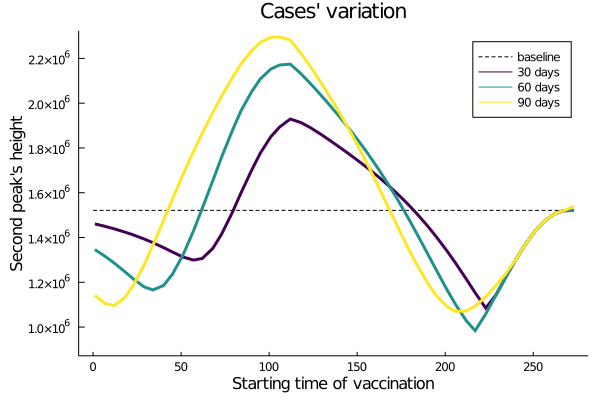

In [45]:
# Plot the absolute height of the second peak for different scenarios

pal = palette(:viridis, 1:3)

plt2 = plot(title = "Cases' variation", ylab = "Second peak's height", xlab = "Starting time of vaccination")
plot!([0, t_peak2],[h_peak_cases2, h_peak_cases2], label = "baseline",
    linestyle=:dash, ylim = [0.6, 1.5]*h_peak_cases2, color = "black", grid = false)
plot!(t_start, df[:,1], color = pal[1], linewidth = 3, label = "30 days" )
plot!(t_start, df[:,2], color = pal[2], linewidth = 3, label = "60 days" )
plot!(t_start, df[:,3], color = pal[3], linewidth = 3, label = "90 days" )